# Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score
from imblearn.over_sampling import SMOTE

# Persiapan Data

In [ ]:
df = pd.read_csv('/content/churn.csv')
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Business/Understanding Data

Informasi yang didapatkan terkait **Business/Understanding Data** ->
Data yang diguanakan adalah **Churn** dimana berhentingnya atau menghilangnya pelanggan dalam menggunakan layanan suatu produk di perusahaan X.

**Masalah** yang dihadapi adalah: Karena adanya churn pelanggan, maka bisa menimbulkan efek kehilangan pendapatan dan harus mengeluarkan biaya lebih untuk menarik pelanggan baru.

Sehingga, perusahaan perlu pelanggan mana yang berpotensi churn guna meminimlisir potensi pelanggan churn dan juga evaluasi kebijakan tim perusahaan nantinya untuk mempertahankan pelanggan supaya terus menggunakan layanan produk di perusahaan X. Hal ini, perlu dilakukan prediksi menggunakan metode **machine learning dengan hypertuning parameter** untuk bisa memprediksi secara optimal terkait potensi churn pelanggan (meningkatkan performa model).

**Harapannya**, sebagai rekomendasi untuk tim perusahaan terutama bisnis dan marketing guna evaluasi produk untuk bisa mempertahankan pelanggan. Selain itu, referensi pengambilan keputusan untuk mempertahankan pelanggan agar tetap menggunakan layanan perusahaan X secara berkelanjutan

Adapun, variabel-variabel yang tertera pada churn, yaitu:
1. Gender (Jenis Kelamin), Senior Citizen (Menunjukkan pelanggan lansia atau tidak), Partner (Menunjukkan apakah pelanggan memiliki pasangan hidup atau tidak), dan Dependents (Menunjukkan apakah pelanggan memiliki tanggungan atau tidak, anak orang tua, dan lainnya) -> **Lingkup Data Demografi**
2. Tenure (Lama pelanggan telah berlangganan), Contract (kontrak pelanggan), PaperlessBilling (penagihan tanpa kertas), dan PaymentMethod (Jenis pembayaran) -> **Lingkup Data Layanan**
3. MonthlyCharges (Biaya langganan per bulan yang dibayar oleh pelanggan), TotalCharges (Total biaya yang sudah dikeluarkan pelanggan sejak pertama kali berlangganan) -> **Lingkup Data Finansial**
4. Churn (Target penentuan pelanggan churn atau tidak) -> **Variabel Target**

In [ ]:
len(df)

7046

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


Interpretasi: Total data keseluruhan 7046, namun ada beberapa data yang kurang lengkap mengindikasikan adanya missing value, nanti kita akan cek. Tipe datanya sudah sesuai. Untuk SeniorCitizen bentuknya 0 dan 1, sehingga kedetect Float64.



# Exploratory Data Analysis (EDA)

## Missing Values

### Cek Missing Value

In [ ]:
## Melihat data yang missing value
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)
customerID,9,0.13
Gender,16,0.23
SeniorCitizen,12,0.17
Partner,16,0.23
Dependents,19,0.27
Tenure,17,0.24
Contract,13,0.18
PaperlessBilling,13,0.18
PaymentMethod,11,0.16
MonthlyCharges,10,0.14


Interpretasi: Setelah dicek missing valuenya, terlihat bahwa variabel-variabel seperti Gender, SeniorCitizen, Partner, Dependents, Tenure, Contract, PaperlessBilling, PaymentMehtod, dan MonthlyCharges mengindikasikan missing value dimana masing-masing < 20%, maka harus dilakukan handling dengan pendekatan mean/median/modus sesuai kriteria/tipe datanya.

Untuk CustomerID -> tidak berguna sehingga tidak perlu dilakukan imputasi

### Handling Missing Value

#### Data Numerik

Melakukan handling missing value pada data numerik, yaitu **Tenure dan MonthlyCharges**. Kita lihat distirbusinya, apakah cocok menggunakan mean atau median. Jikalau ada kecenderungan skewness maka cocok menggunakan median, jika tidak terlalu skewness maka menggunakan Mean. Namun, dianjurkan menggunakan median agar robust terhadap outlier.

In [ ]:
numerik_df = ['Tenure', 'MonthlyCharges']

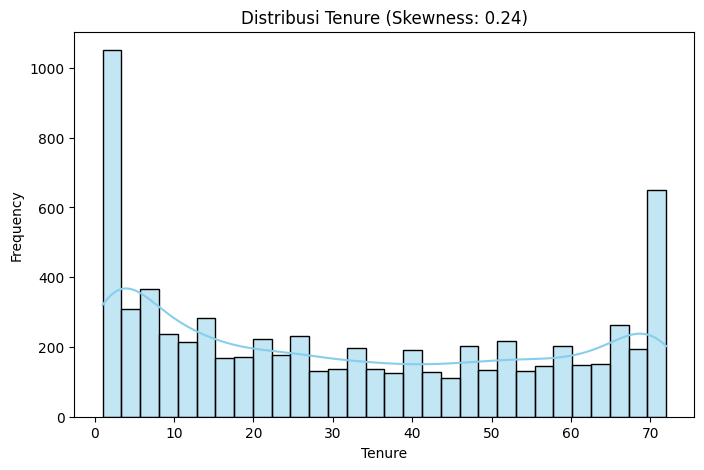

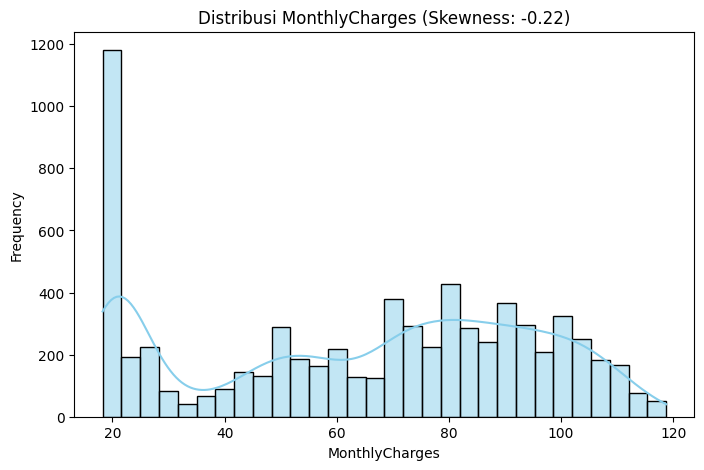

In [ ]:
# Cek skewness
skewness = df[numerik_df].skew()
# Loop untuk setiap kolom numerik
for col in numerik_df:
    skewness = df[col].skew()

    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribusi {col} (Skewness: {skewness:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Interpetasi:
Karena cenderung skewness sedikit, dimana Tenure untuk condong ke kanan sedikit dan MonthlyCharges untuk condong ke kiri. Sehingga, boleh menggunakan mean dalam pendekatan handlingnya, namun saya menggunakan **median** untuk lebih aman dan robust terhadap outlier.

In [ ]:
#Handling With Median
for col in numerik_df:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)
    print(f"Missing value pada '{col}' telah diisi dengan median: {median_value}")

Missing value pada 'Tenure' telah diisi dengan median: 29.0
Missing value pada 'MonthlyCharges' telah diisi dengan median: 70.35


<ipython-input-439-b1c48e9a3daf>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


In [ ]:
#Recheck
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)
customerID,9,0.13
Gender,16,0.23
SeniorCitizen,12,0.17
Partner,16,0.23
Dependents,19,0.27
Contract,13,0.18
PaperlessBilling,13,0.18
PaymentMethod,11,0.16


Okay aman. Lanjut Handling Data Kategorik.

#### Data Kategorik

Melakukan handling missing value pada data kategorik, yaitu **Gender, SeniorCitizen, Partner, Dependents, Contract, PaperlessBilling, dan PaymentMethod** menggunakan pendekatan modus. Untuk SeniorCitizen kan tipenya numerik, tapi setelah dicek dia bentuknya kategorikal 0 dan 1, sehingga perlu dihandling menggunakan pendekatan modus.

In [ ]:
# List kolom kategorikal yang akan diisi missing value-nya dengan modus
kategori_df = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
               'Contract', 'PaperlessBilling', 'PaymentMethod']

In [ ]:
# Imputasi missing value dengan modus
for col in kategori_df:
    mode_value = df[col].mode()[0]  # ambil nilai modus (terbanyak)
    df[col].fillna(mode_value, inplace=True)
    print(f"Missing value pada '{col}' telah diisi dengan modus: {mode_value}")

Missing value pada 'Gender' telah diisi dengan modus: Male
Missing value pada 'SeniorCitizen' telah diisi dengan modus: 0.0
Missing value pada 'Partner' telah diisi dengan modus: No
Missing value pada 'Dependents' telah diisi dengan modus: No
Missing value pada 'Contract' telah diisi dengan modus: Month-to-month
Missing value pada 'PaperlessBilling' telah diisi dengan modus: Yes
Missing value pada 'PaymentMethod' telah diisi dengan modus: Electronic check


<ipython-input-442-3a1ce7359229>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [ ]:
#Recheck 2
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage (%)': missing_percent.round(2)
})

missing_df[missing_df['Missing Values'] > 0]  # tampilkan hanya yang ada missing-nya

,Missing Values,Percentage (%)
customerID,9,0.13


**CustomerID** tidak usah, karena tidak berpengaruh terhadap analisis alias tidak digunakan. Sehingga, okay aman, lanjut kita coba cek value aneh dari masing-masing variabel kategorik. Jikalau ada, maka dilakukan handling.

###### Cek Value Aneh Pada Data Kategorik

In [ ]:
# Cek value_counts untuk mendeteksi nilai yang aneh di kolom kategorikal
Kategorifull_df = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
               'Contract', 'PaperlessBilling', 'PaymentMethod']
for column in Kategorifull_df:
    print(f"============= {column} =================")
    display(df[column].value_counts(dropna=False))  # dropna=False untuk lihat missing juga kalau ada
    print()

============= Gender =================


,count
Gender,
Male,3568
Female,3478



============= SeniorCitizen =================


,count
SeniorCitizen,
0.0,5904
1.0,1142



============= Partner =================


,count
Partner,
No,3654
Yes,3392



============= Dependents =================


,count
Dependents,
No,4950
Yes,2096



============= Contract =================


,count
Contract,
Month-to-month,3886
Two year,1689
One year,1471



============= PaperlessBilling =================


,count
PaperlessBilling,
Yes,4181
No,2865



============= PaymentMethod =================


,count
PaymentMethod,
Electronic check,2378
Mailed check,1604
Bank transfer (automatic),1540
Credit card (automatic),1524


Interpretasi: Tidak ada value aneh dari masing-masing variabel kategorik. Maka, lanjut ke cek dan handling Outliers.

## Outliers

### Cek Outliers

Pengecekan outlier pada variabel-variabel numerik, yaitu **Tenure, MonthlyCharges, dan TotalCharges**.

In [ ]:
numerik_df = ['Tenure', 'MonthlyCharges', 'TotalCharges']

Variabel Tenure:


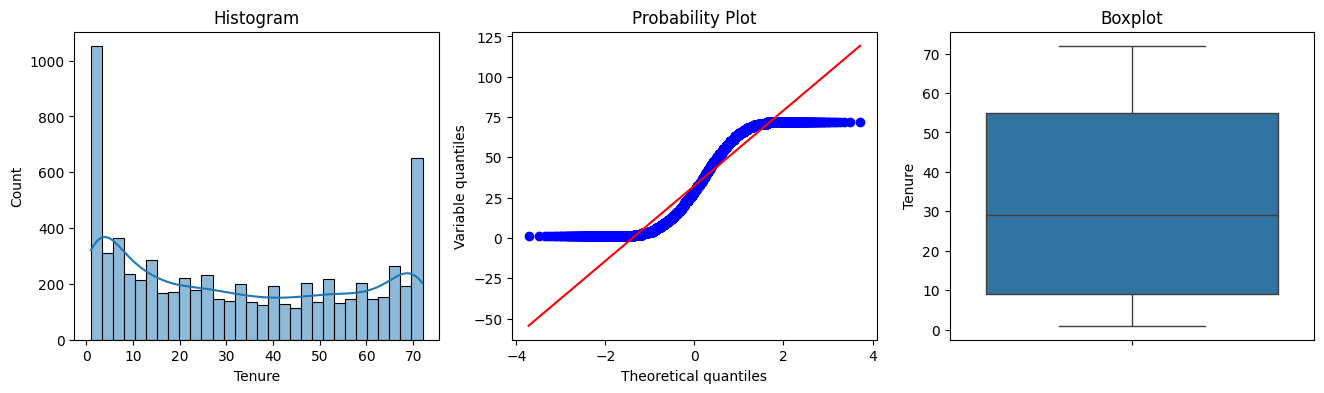

Variabel MonthlyCharges:


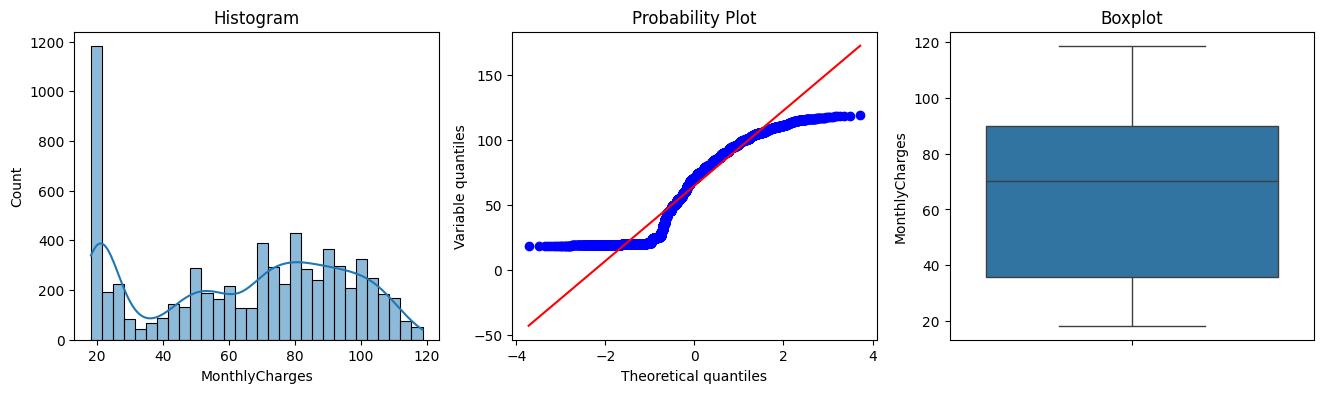

Variabel TotalCharges:


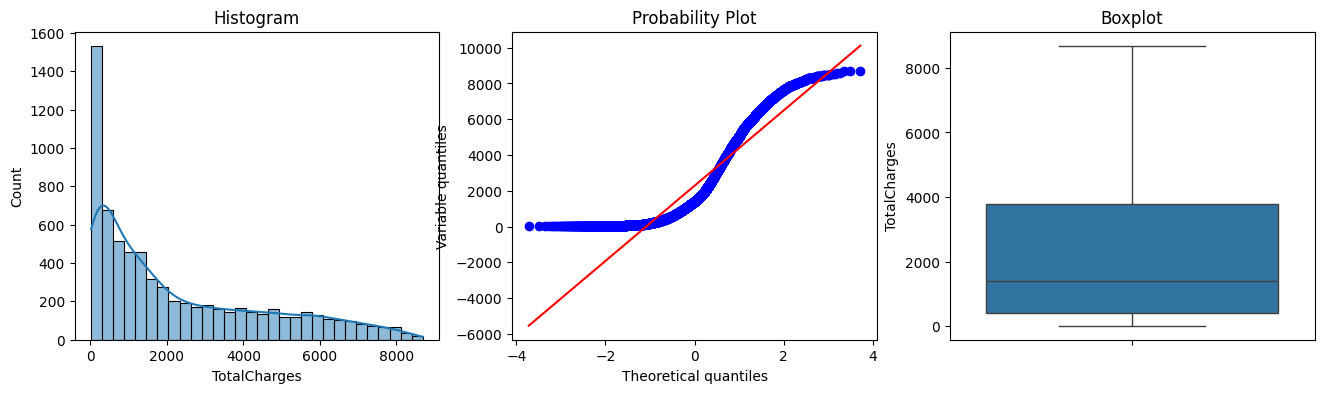

In [ ]:
#Cek dengan plot
def check_outlier(df, variable):

  print(f'Variabel {variable}:')

  #ukuran gambar
  plt.figure(figsize=(16,4))

  #histogram
  plt.subplot(1, 3, 1)
  sns.histplot(df[variable], kde=True, bins=30)
  plt.title('Histogram')

  #boxplot
  plt.subplot(1, 3, 3)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')


  #probplot
  plt.subplot(1, 3, 2)
  stats.probplot(df[variable], dist="norm", plot=plt)
  plt.ylabel('Variable quantiles')

  plt.show()

for i in numerik_df:
  check_outlier(df, i)

Interpretasi:
Setelah dilakukan pengecekan, dapat didapatkan bahwa:

**Variabel Tenure:**
- Histogram: Cenderung membentuk skewness sedikit condong ke kanan
- QQ Plot: cenderung mendekati garis linear (tidak begitu ada data yang ekstrem)
- Boxplot: Tidak ada data ekstrem atau keluar dari batas maksimum/minimum
Sehingga, diindikasikan variabel Tenure tidak ada outlier, namun kita nanti perlu cek dengan IQR biar lebih akurat.

**Variabel MonthlyCharges:**
- Histogram: Cenderung membentuk skewness sedikit condong ke kiri
- QQ Plot: cenderung mendekati garis linear (tidak begitu ada data yang ekstrem)
- Boxplot: Tidak ada data ekstrem atau keluar dari batas maksimum/minimum
Sehingga, diindikasikan variabel MonthlyCharges tidak ada outlier, namun kita nanti perlu cek dengan IQR biar lebih akurat.

**Variabel TotalCharges:**
- Histogram: Cenderung membentuk skewness sedikit condong ke kiri
- QQ Plot: cenderung mendekati garis linear (tidak begitu ada data yang ekstrem)
- Boxplot: Tidak ada data ekstrem atau keluar dari batas maksimum/minimum
Sehingga, diindikasikan variabel TotalCharges tidak ada outlier, namun kita nanti perlu cek dengan IQR biar lebih akurat.

### Handling Outliers

In [ ]:
def detect_outlier_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"\nKolom: {column}")
    print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"Jumlah outlier: {outliers.shape[0]}")
    return outliers

# Jalankan untuk tiap kolom numerik
for col in numerik_df:
    detect_outlier_iqr(df, col)



Kolom: Tenure
Q1: 9.00, Q3: 55.00, IQR: 46.00
Lower Bound: -60.00, Upper Bound: 124.00
Jumlah outlier: 0

Kolom: MonthlyCharges
Q1: 35.71, Q3: 89.85, IQR: 54.14
Lower Bound: -45.49, Upper Bound: 171.06
Jumlah outlier: 0

Kolom: TotalCharges
Q1: 401.35, Q3: 3791.00, IQR: 3389.65
Lower Bound: -4683.12, Upper Bound: 8875.48
Jumlah outlier: 0


Interpretasi: Setelah Dicek dengan pendekatan IQR, ditemukan bahwa tidak ada outlier pada masing-masing Variabel numerik, yaitu Tenure, MonthlyCharges, dan TotalCharges. Sehingga, tidak perlu dihandling dan lanjut ke cek duplikasi.

## Cek Duplikasi Data

In [ ]:
# Cek jumlah baris duplikat
duplikat = df.duplicated()
print(f"Jumlah data duplikat: {duplikat.sum()}")

Jumlah data duplikat: 14


Perlu kita cek

In [ ]:
# Cek duplikat CustomerID
duplikat = df[df.duplicated()]
print(f"Jumlah data yang duplikat: {duplikat.shape[0]}")
duplikat

Jumlah data yang duplikat: 14


,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7032,2905-KFQUV,Female,0.0,Yes,No,2.0,Month-to-month,Yes,Credit card (automatic),70.40,154.80,No
7033,9253-QXKBE,Male,1.0,Yes,No,29.0,Month-to-month,Yes,Electronic check,94.45,2653.65,Yes
7034,6418-HNFED,Male,0.0,Yes,No,51.0,Two year,Yes,Credit card (automatic),83.25,4089.45,No
7035,4795-UXVCJ,Male,0.0,No,No,26.0,One year,No,Credit card (automatic),19.80,457.30,No
7036,3606-SBKRY,Male,0.0,No,No,31.0,One year,Yes,Electronic check,50.05,1523.40,No
7037,5233-GEEAX,Male,1.0,No,No,8.0,Month-to-month,Yes,Electronic check,29.40,221.90,Yes
7038,6000-UKLWI,Male,0.0,No,No,41.0,Two year,No,Mailed check,20.15,802.35,No
7039,2236-HILPA,Male,0.0,Yes,Yes,62.0,Two year,No,Credit card (automatic),20.65,1218.45,No
7040,2342-CKIAO,Female,0.0,No,No,2.0,Month-to-month,No,Mailed check,20.30,41.20,No
7041,5067-WJEUN,Male,0.0,Yes,Yes,67.0,Two year,Yes,Bank transfer (automatic),54.20,3838.20,No


Setelah dicek, tidak ada yang mirip sama sekali plek, jadi tidak ada case duplikasi data. Sehingga, lanjut EDA - Business Question Key (Feature Extraction)

# EDA - Business Question Key (Feature Extraction)

In [ ]:
df_BQK = df.copy()
df_BQK.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,No,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Okey, sebelum masuk step selanjutnya, kita coba breakdown mengenai beberapa insight question case terkait churn dataset yang bisa kita tau:

1. Apakah pelanggan dengan kontrak "Month-to-month" lebih berisiko churn dibandingkan kontrak lain?
2. Apakah pelanggan dengan tenure < 12 bulan lebih banyak churn dibandingkan yang tenure >= 12 bulan?
3. Segmen mana yang membayar rata-rata MonthlyCharges paling tinggi?

## 1. Apakah pelanggan dengan kontrak "Month-to-month" lebih berisiko churn dibandingkan kontrak lain?

In [ ]:
# Convert Churn jadi numeric di dataframe EDA
df_BQK['Churn'] = df_BQK['Churn'].map({'Yes':1, 'No':0})

# Sekarang bisa .mean() tanpaw error
contract_churn = df_BQK.groupby('Contract')['Churn'].mean().sort_values(ascending=False)
print(contract_churn)

Contract
Month-to-month    0.426917
One year          0.112169
Two year          0.028419
Name: Churn, dtype: float64


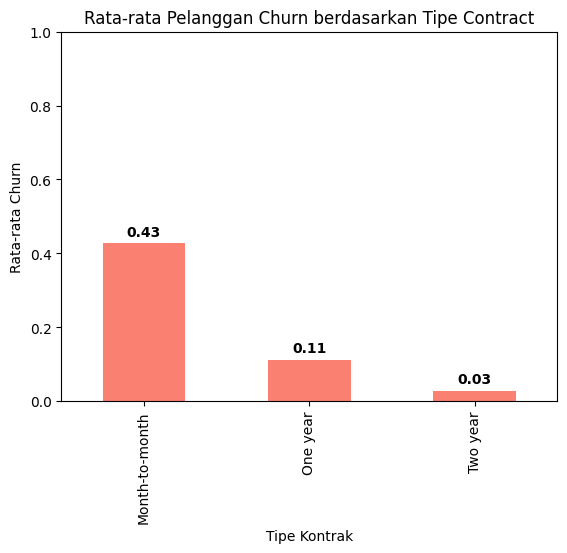

In [ ]:
contract_churn.plot(kind='bar', color='salmon')
plt.title('Rata-rata Pelanggan Churn berdasarkan Tipe Contract')
plt.ylabel('Rata-rata Churn')
plt.xlabel('Tipe Kontrak')
plt.ylim(0,1)
# Tambah data label di atas bar
for idx, value in enumerate(contract_churn):
    plt.text(idx, value + 0.02, f'{value:.2f}', ha='center', fontweight='bold')
plt.show()

Interpretasi:
- Pelanggan dengan kontrak bulanan (month-to-month) lebih sering churn (putus layanan) **sebesar 43%** dibandingkan pelanggan dengan kontrak tahunan atau dua tahunan. Hal ini logis karena pelanggan "month-to-month" lebih fleksibel keluar tanpa penalti, sehingga risiko churn mereka lebih tinggi.
- Pelanggan kontrak 2 tahun sebagai tingkat churn terendah **sebesar 3%**, hal ini cenderung lebih loyal atau "terikat" karena mungkin ada diskon atau penalti jika berhenti sebelum masa kontrak habis.

Rekomendasi:
- Perusahaan bisa mempertimbangkan untuk meningkatkan insentif bagi pelanggan "month-to-month" supaya beralih ke kontrak jangka panjang (misal: diskon, bonus layanan tambahan).

- Atau melakukan kampanye retensi yang lebih kuat untuk pelanggan dengan kontrak month-to-month.



## 2. Apakah pelanggan dengan tenure < 12 bulan lebih banyak churn dibandingkan yang tenure >= 12 bulan?

In [ ]:
df_BQK['Tenure_Group'] = df_BQK['Tenure'].apply(lambda x: '<12' if x < 12 else '>=12')

In [ ]:
tenure_churn = df_BQK.groupby('Tenure_Group')['Churn'].mean().sort_values(ascending=False)
print(tenure_churn)

Tenure_Group
<12     0.485673
>=12    0.174855
Name: Churn, dtype: float64


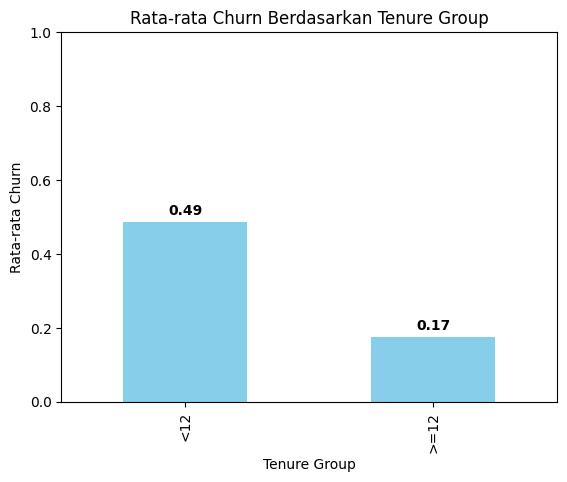

In [ ]:
tenure_churn.plot(kind='bar', color='skyblue')
plt.title('Rata-rata Churn Berdasarkan Tenure Group')
plt.ylabel('Rata-rata Churn')
plt.xlabel('Tenure Group')
plt.ylim(0,1)

for idx, value in enumerate(tenure_churn):
    plt.text(idx, value + 0.02, f'{value:.2f}', ha='center', fontweight='bold')

plt.show()


Interpretasi:
Pelanggan dengan Tenur < 12 bulan mendominasi dibandingkan => 12 yaitu **sebesar 49%**. Sementara yang >= 12 bulan hanya 17% saja. Hal ini membuktikan bahwa pelanggan baru atau yang masih di bawah 1 tahun berlangganan lebih rentan untuk churn dan behavior pelanggan baru cenderung belum terlalu loyal dan lebih cepat putus langganan.

Sehingga, rekomendasi untuk perusahaan yaitu diharapkan perusahaan bisa membuat program onboarding atau early engagement untuk pelanggan baru (0-12 bulan), misalnya promo khusus 6 bulan pertama. Selain itu, juga bisa membuat program insentif tambahan untuk pelanggan baru selain promo khusus, misalkan paket bundling atau lainnya. Dengan demikian, bisa mengantisipasi pelanggan churn kedepannya.

## 3. Segmen mana yang membayar rata-rata MonthlyCharges

In [ ]:
monthly_avg = df_BQK.groupby('Contract')['MonthlyCharges'].mean().sort_values(ascending=False)
print(monthly_avg)

Contract
Month-to-month    66.415466
One year          65.023521
Two year          60.923002
Name: MonthlyCharges, dtype: float64


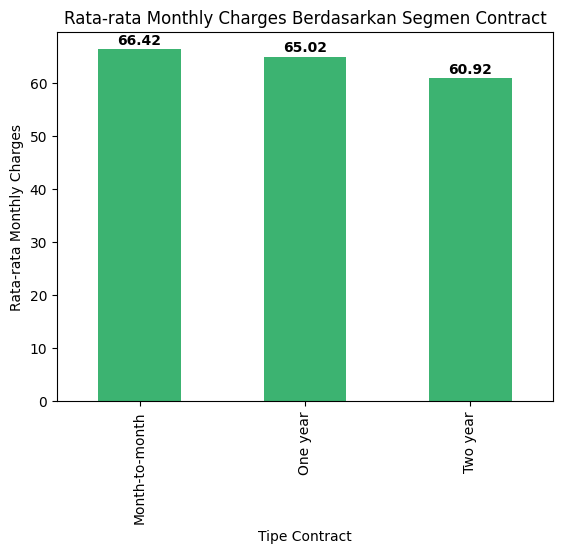

In [ ]:
monthly_avg.plot(kind='bar', color='mediumseagreen')
plt.title('Rata-rata Monthly Charges Berdasarkan Segmen Contract')
plt.ylabel('Rata-rata Monthly Charges')
plt.xlabel('Tipe Contract')

for idx, value in enumerate(monthly_avg):
    plt.text(idx, value + 1, f'{value:.2f}', ha='center', fontweight='bold')

plt.show()

Interpretasi: Pelanggan Month-to-month membayar rata-rata paling tinggi yaitu **sebesar 66,42 (satuan dollar)**. Hal ini menunjukkan bahwa, pelanggan membayar mahal pada jangan waktu bulanan daripada berjangka panjang (1 tahun atau dua tahun) Mungkin, bisa jadi karena biasanya karena kontrak jangka panjang sering dapat diskon atau harga promo.

Rekomendasi:
- Upsell pelanggan "month-to-month" ke kontrak jangka panjang, agar Revenue tetap stabil (meskipun per bulan lebih murah, tapi secara lifetime value lebih tinggi) dan juga mengurangi dampak pelanggan churn.
- Perusahaan membuat Paket bundling / loyalty program -> untuk pelanggan month-to-month agar merasa lebih "terikat" dan mendapatkan lebih banyak value sehingga mereka tidak merasa terbebani dengan biaya tinggi per bulan.


Kita Breakdown berdasarkan Payment Method.

In [ ]:
#Payment method
payment_charge = df_BQK.groupby('PaymentMethod')['MonthlyCharges'].mean().sort_values(ascending=False)
print(payment_charge)

PaymentMethod
Electronic check             76.215391
Bank transfer (automatic)    67.183961
Credit card (automatic)      66.456234
Mailed check                 44.050031
Name: MonthlyCharges, dtype: float64


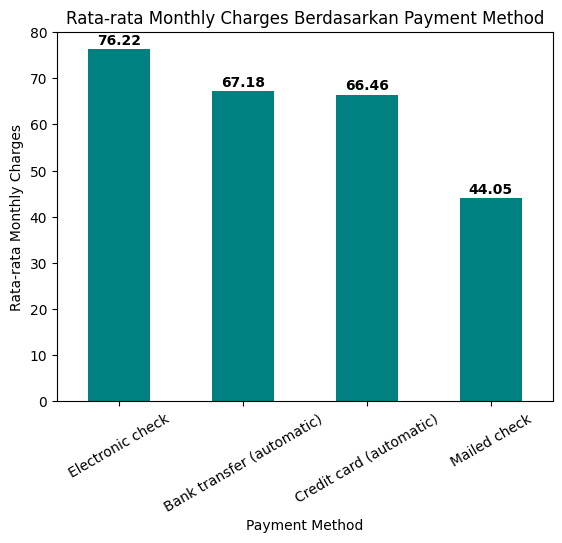

In [ ]:
payment_charge.plot(kind='bar', color='teal')
plt.title('Rata-rata Monthly Charges Berdasarkan Payment Method')
plt.ylabel('Rata-rata Monthly Charges')
plt.xlabel('Payment Method')

for idx, value in enumerate(payment_charge):
    plt.text(idx, value + 1, f'{value:.2f}', ha='center', fontweight='bold')

plt.xticks(rotation=30)
plt.show()


Interpretasi: Kita breakdown lagi berdasarkan 'Payment Method' dimana credit card dan bank transfer umumnya cenderung biasanya di segmen pelanggan premium (tagihan rata-rata lebih tinggi). Sedangkan, untuk Electronic check sering muncul biasanya di pelanggan yang churn dan juga membayar lebih rendah rata-ratanya.

Rekomendasi:
- Jika Electronic check banyak dipakai pelanggan yang churn, maka mendorong pelanggan untuk beralih ke auto-debit / credit card (misalnya dengan promo atau cashback) agar mereka lebih "komitmen".
- Selalu Memonitoring churn rate per payment method, karena metode pembayaran bisa menjadi early signal risiko churn.

Lanjut Splitting Data.

# Splitting Dataset

Melakukan splitting dataset menjadi Training dan Testing (80:20)

In [ ]:
X = df.drop(columns=['Churn','customerID']).to_numpy()
y = df[['Churn']].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (5636, 10)
X_test shape : (1410, 10)
y_train shape: (5636,)
y_test shape : (1410,)


# Analisis Korelasi dan Seleksi Fitur

Melakukan analisis korelasi dan seleksi fitur menggunakan heatmap korelasi dan pendekatan VIF pada Data Training. Terutama Pada data numerik.


In [ ]:
# Urutan kolom
columns = df.drop(columns=['Churn', 'customerID']).columns.tolist()

# Index kolom yang kamu mau
idx = [columns.index(col) for col in ['Tenure', 'MonthlyCharges', 'TotalCharges']]

# Akses dari X_train
X_train[:, idx]
X_train_numerik = X_train[:, idx]
X_train_numerik_df = pd.DataFrame(X_train_numerik, columns=numerik_df)

In [ ]:
X_train_numerik_df.head()

,Tenure,MonthlyCharges,TotalCharges
0,58.0,95.3,5817.7
1,5.0,85.4,425.9
2,70.0,25.15,1940.85
3,61.0,82.15,4904.85
4,16.0,65.2,1043.35


In [ ]:
print(X_train_numerik_df.dtypes)

Tenure            object
MonthlyCharges    object
TotalCharges      object
dtype: object


Interpretasi: Karena tipenya berubah jadi object, maka kita rubah menjadi numerik.

In [ ]:
for col in X_train_numerik_df.columns:
    X_train_numerik_df[col] = pd.to_numeric(X_train_numerik_df[col], errors='coerce')

In [ ]:
# Kalkulasi Skor VIF

X = add_constant(X_train_numerik_df)

# Hitung VIF
skor_vif = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])],
                        index=X.columns).reset_index()
skor_vif.columns = ['feature', 'vif_score']

# Drop konstanta
skor_vif = skor_vif.loc[skor_vif.feature != 'const']
print(skor_vif)

          feature  vif_score
1          Tenure   5.703902
2  MonthlyCharges   3.171221
3    TotalCharges   9.278543


Interpretasi -> Nilai VIF digunakan untuk mendeteksi variabel mana yang mengindikasikan kecenderungan terjadinya multikolinearitas. Ternyata nilai VIF tertinggi: TotalCharges yaitu sebesar 9,27. Selanjutnya, kita cek dengan heatmap correlation untuk menyeleksi fitur.

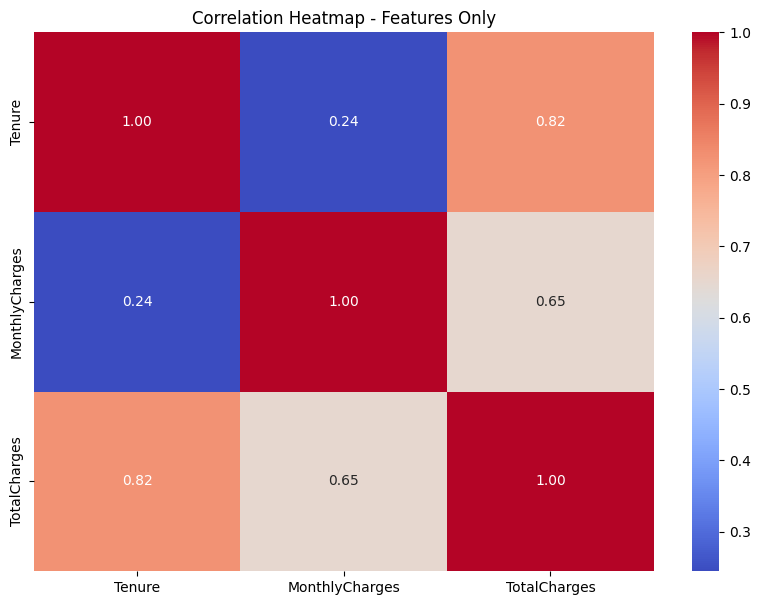

In [ ]:
# Cukup ini aja buat cek korelasi antar fitur numerik
corr = X_train_numerik_df.corr()

# Visualisasinya
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap - Features Only')
plt.show()

Interpretasi ->
- Korelasi tinggi antar variabel independen (X) bisa menyebabkan multikolinearitas, yang dapat membuat model regresi menjadi kurang stabil.
- Menggunakan asumsi Threshold r > 0,8 -> maka berpotensi kuat terjadi multikolienearitas. Maka, variabel Total Charges dan Tenure (0,82) tinggi sekali dan indikasi multikolinearitas. Berdasarkan VIF, maka kita langsung drop out **TotalCharges**.
- Untuk sisanya nilai r < 0,8 jadi tetap masuk analisis.

Sehingga, yang masuk pada analisis untuk numerik : **Tenure dan Monthly Charges**

In [ ]:
X_train

array([['Female', 0.0, 'No', 'No', 58.0, 'Month-to-month', 'Yes', 'Electronic check', 95.3, 5817.7],
       ['Female', 0.0, 'No', 'No', 5.0, 'Month-to-month', 'Yes', 'Credit card (automatic)', 85.4, 425.9],
       ['Male', 0.0, 'Yes', 'No', 70.0, 'Two year', 'No', 'Bank transfer (automatic)', 25.15, 1940.85],
       ['Male', 1.0, 'Yes', 'No', 61.0, 'Month-to-month', 'Yes', 'Electronic check', 82.15, 4904.85],
       ['Female', 0.0, 'No', 'No', 16.0, 'Month-to-month', 'Yes', 'Credit card (automatic)', 65.2, 1043.35],
       ['Male', 0.0, 'Yes', 'Yes', 54.0, 'Two year', 'No', 'Credit card (automatic)', 20.4, 1090.6],
       ['Male', 0.0, 'Yes', 'No', 3.0, 'Month-to-month', 'Yes', 'Mailed check', 55.8, 154.55],
       ['Male', 0.0, 'Yes', 'No', 27.0, 'One year', 'No', 'Credit card (automatic)', 48.7, 1421.75],
       ['Female', 0.0, 'Yes', 'Yes', 71.0, 'Two year', 'No', 'Mailed check', 91.05, 6293.75],
       ['Male', 0.0, 'No', 'No', 6.0, 'Month-to-month', 'No', 'Mailed check', 60.9, 414

In [ ]:
#drop TotalCharges in X train
X_train = np.delete(X_train, -1, axis=1)
X_test = np.delete(X_test, -1, axis=1)

In [ ]:
X_train

array([['Female', 0.0, 'No', 'No', 58.0, 'Month-to-month', 'Yes', 'Electronic check', 95.3],
       ['Female', 0.0, 'No', 'No', 5.0, 'Month-to-month', 'Yes', 'Credit card (automatic)', 85.4],
       ['Male', 0.0, 'Yes', 'No', 70.0, 'Two year', 'No', 'Bank transfer (automatic)', 25.15],
       ['Male', 1.0, 'Yes', 'No', 61.0, 'Month-to-month', 'Yes', 'Electronic check', 82.15],
       ['Female', 0.0, 'No', 'No', 16.0, 'Month-to-month', 'Yes', 'Credit card (automatic)', 65.2],
       ['Male', 0.0, 'Yes', 'Yes', 54.0, 'Two year', 'No', 'Credit card (automatic)', 20.4],
       ['Male', 0.0, 'Yes', 'No', 3.0, 'Month-to-month', 'Yes', 'Mailed check', 55.8],
       ['Male', 0.0, 'Yes', 'No', 27.0, 'One year', 'No', 'Credit card (automatic)', 48.7],
       ['Female', 0.0, 'Yes', 'Yes', 71.0, 'Two year', 'No', 'Mailed check', 91.05],
       ['Male', 0.0, 'No', 'No', 6.0, 'Month-to-month', 'No', 'Mailed check', 60.9],
       ['Male', 0.0, 'Yes', 'Yes', 51.0, 'One year', 'No', 'Electronic check',

In [ ]:
X_test

array([['Female', 0.0, 'Yes', 'No', 1.0, 'Month-to-month', 'Yes', 'Electronic check', 24.8],
       ['Female', 0.0, 'Yes', 'Yes', 24.0, 'Two year', 'Yes', 'Mailed check', 19.7],
       ['Female', 1.0, 'No', 'No', 56.0, 'Two year', 'No', 'Bank transfer (automatic)', 73.25],
       ['Female', 0.0, 'No', 'No', 72.0, 'Two year', 'Yes', 'Bank transfer (automatic)', 21.15],
       ['Male', 0.0, 'No', 'No', 67.0, 'Two year', 'No', 'Bank transfer (automatic)', 50.55],
       ['Female', 0.0, 'No', 'No', 7.0, 'Month-to-month', 'No', 'Mailed check', 20.65],
       ['Female', 0.0, 'No', 'No', 52.0, 'One year', 'Yes', 'Credit card (automatic)', 111.25],
       ['Female', 0.0, 'No', 'Yes', 9.0, 'Month-to-month', 'Yes', 'Mailed check', 72.9],
       ['Male', 0.0, 'Yes', 'Yes', 34.0, 'One year', 'No', 'Bank transfer (automatic)', 30.4],
       ['Female', 0.0, 'Yes', 'No', 49.0, 'One year', 'No', 'Credit card (automatic)', 20.7],
       ['Male', 0.0, 'No', 'No', 2.0, 'Month-to-month', 'No', 'Mailed che

# Encoding Data

- Melakukan encoding untuk data kategorikal menjadi numerik dengan pendekatan aturan encoding sebagai pelabelan untuk machine learning.
- Memilih data kategorikal, **yaitu 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod', dan 'Churn'**

In [ ]:
kolom_kategori = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [ ]:
fitur = df.drop(columns=['Churn','TotalCharges','customerID']).columns
X_train = pd.DataFrame(X_train, columns=fitur)
X_test = pd.DataFrame(X_test, columns=fitur)

In [ ]:
for column in kolom_kategori:
    print(f"============= {column} =================")
    display(X_train[column].value_counts())
    print()

============= Gender =================


,count
Gender,
Male,2857
Female,2779



============= SeniorCitizen =================


,count
SeniorCitizen,
0.0,4724
1.0,912



============= Partner =================


,count
Partner,
No,2942
Yes,2694



============= Dependents =================


,count
Dependents,
No,3961
Yes,1675



============= Contract =================


,count
Contract,
Month-to-month,3125
Two year,1337
One year,1174



============= PaperlessBilling =================


,count
PaperlessBilling,
Yes,3349
No,2287



============= PaymentMethod =================


,count
PaymentMethod,
Electronic check,1902
Mailed check,1283
Credit card (automatic),1226
Bank transfer (automatic),1225


In [ ]:
y_train = pd.DataFrame(y_train, columns=['Churn'])

Okay tidak ada kategori yang aneh. Sehingga diencoding untuk data kategoriknya.
- Variabel yang memiliki binary kategori -> Label Encoder (PaperlessBilling, Dependents, Partner, SeniorCitizen, Gender, dan Churn)
- Selain binary maka menggunakan -> OHE (PaymentMethod, Contract)

## Label Encoder

### Training

In [ ]:
# Binary untuk X
X_binary_cols = ['PaperlessBilling', 'Dependents', 'Partner', 'SeniorCitizen', 'Gender']
# Buat dictionary encoder per kolom
label_encoders = {}

for col in X_binary_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    label_encoders[col] = le  # simpan encoder-nya


In [ ]:
X_train.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,0,0,0,58.0,Month-to-month,1,Electronic check,95.3
1,0,0,0,0,5.0,Month-to-month,1,Credit card (automatic),85.4
2,1,0,1,0,70.0,Two year,0,Bank transfer (automatic),25.15
3,1,1,1,0,61.0,Month-to-month,1,Electronic check,82.15
4,0,0,0,0,16.0,Month-to-month,1,Credit card (automatic),65.2


In [ ]:
#Binary untuk Y
label_encoderss = {}
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train.values.ravel())
y_train = pd.DataFrame(y_train, columns=['Churn'])
label_encoderss['Churn'] = le_target # simpan encoder-nya

In [ ]:
y_train.head()

,Churn
0,0
1,1
2,0
3,0
4,1


### Testing

In [ ]:
#transform dari train X_Binary
for col in X_binary_cols:
    le = label_encoders[col]
    X_test[col] = le.transform(X_test[col])  # pakai encoder yang sesuai kolom

In [ ]:
X_test.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,0,1,0,1.0,Month-to-month,1,Electronic check,24.8
1,0,0,1,1,24.0,Two year,1,Mailed check,19.7
2,0,1,0,0,56.0,Two year,0,Bank transfer (automatic),73.25
3,0,0,0,0,72.0,Two year,1,Bank transfer (automatic),21.15
4,1,0,0,0,67.0,Two year,0,Bank transfer (automatic),50.55


In [ ]:
#transform dari train untuk Y_binary
# Ambil encoder yang sudah disimpan dari training
le_target = label_encoderss['Churn']

# Pastikan y_test dalam format array 1D
y_test = le_target.transform(y_test.ravel())

# Simpan lagi dalam bentuk DataFrame
y_test = pd.DataFrame(y_test, columns=['Churn'])

In [ ]:
y_test.head()

,Churn
0,1
1,0
2,0
3,0
4,0


In [ ]:
#Recheck
len(X_train), len(X_test), len(y_train), len(y_test)

(5636, 1410, 5636, 1410)

## One Hot Encoding

### Training

In [ ]:
#OHE variabel Contract dan PaymentMethod
ohe_cols = ['PaymentMethod', 'Contract']
X_train = pd.get_dummies(X_train, columns=ohe_cols, drop_first=True)

In [ ]:
X_train.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year
0,0,0,0,0,58.0,1,95.3,False,True,False,False,False
1,0,0,0,0,5.0,1,85.4,True,False,False,False,False
2,1,0,1,0,70.0,0,25.15,False,False,False,False,True
3,1,1,1,0,61.0,1,82.15,False,True,False,False,False
4,0,0,0,0,16.0,1,65.2,True,False,False,False,False


### Testing

In [ ]:
#OHE variabel Contract dan PaymentMethod
# OHE untuk X_test
X_test = pd.get_dummies(X_test, columns=ohe_cols, drop_first=True)

# Reindex kolom test agar sama dengan train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [ ]:
X_test.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year
0,0,0,1,0,1.0,1,24.8,False,True,False,False,False
1,0,0,1,1,24.0,1,19.7,False,False,True,False,True
2,0,1,0,0,56.0,0,73.25,False,False,False,False,True
3,0,0,0,0,72.0,1,21.15,False,False,False,False,True
4,1,0,0,0,67.0,0,50.55,False,False,False,False,True


In [ ]:
#Recheck2
len(X_train), len(X_test), len(y_train), len(y_test)

(5636, 1410, 5636, 1410)

Okay data sudah terencoding sempurna, sehingga lanjut masuk scalling data karena saya akan menggunakan beberaapa model, terutama **KNN dan SVM** yang membutuhkan scalling karena berkaitan dengan jarak/distance. Sehingga, wajib **discalling**

# Scalling Data

Scalling menggunakan Standar Scaller bagus dan cocok untuk untuk KNN, Logistic Regression, dan SVM karena karakteristik ketiga model itu sangat sensitif terhadap skala fitur. StandardScaler akan men-transformasi data menjadi distribusi dengan mean = 0 dan standar deviasi = 1.

In [ ]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

## Training

In [ ]:
#pisahkan numerik dan non numerik
numerik_df = ['Tenure', 'MonthlyCharges']
non_numerik_df = [col for col in X_train_scaled.columns if col not in numerik_df]

Scalling yang numerik saja

In [ ]:
scaler = StandardScaler()
numerik_scaled = scaler.fit_transform(X_train_scaled[numerik_df])

In [ ]:
#gabung
X_train_scaled = pd.concat([
    X_train_scaled[non_numerik_df].reset_index(drop=True),
    pd.DataFrame(numerik_scaled, columns=numerik_df)
], axis=1)

In [ ]:
X_train_scaled.head()

,Gender,SeniorCitizen,Partner,Dependents,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,Tenure,MonthlyCharges
0,0,0,0,0,1,False,True,False,False,False,1.046935,1.020274
1,0,0,0,0,1,True,False,False,False,False,-1.115102,0.691364
2,1,0,1,0,0,False,False,False,False,True,1.536453,-1.310335
3,1,1,1,0,1,False,True,False,False,False,1.169315,0.583388
4,0,0,0,0,1,True,False,False,False,False,-0.666378,0.020255


## Testing

In [ ]:
numerik_scaled_2 = scaler.transform(X_test_scaled[numerik_df])

In [ ]:
#gabung
X_test_scaled = pd.concat([
    X_test_scaled[non_numerik_df].reset_index(drop=True),
    pd.DataFrame(numerik_scaled_2, columns=numerik_df)
], axis=1)

In [ ]:
X_test_scaled.head()

,Gender,SeniorCitizen,Partner,Dependents,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,Tenure,MonthlyCharges
0,0,0,1,0,1,False,True,False,False,False,-1.278275,-1.321963
1,0,0,1,1,1,False,False,True,False,True,-0.340032,-1.491401
2,0,1,0,0,0,False,False,False,False,True,0.965349,0.287702
3,0,0,0,0,1,False,False,False,False,True,1.618039,-1.443228
4,1,0,0,0,0,False,False,False,False,True,1.414074,-0.466465


# Pelatihan Model + Metrik Evaluasi

In [ ]:
y_train.value_counts()

,count
Churn,
0,4143
1,1493


Interpretasi: Karena perbedaan jumlah kelasnya terlalu jauh, maka data imbalanced, sehingga pemilihan metrik evaluasi menggunakan Akurasi tidak cocok/tidak tepat. Maka bisa menggunakan, Recall, F-1 Score, atau Precision.

Dalam pelatihan model ini, digunakan beberapa algoritma machine learning seperti **K-Nearest Neighbors (KNN), Decision Tree, Random Forest, Logistic Regression, dan Support Vector Machine (SVM)** untuk memprediksi churn pelanggan.

Untuk metrik evaluasi, dipilih **Recall** sebagai fokus utama karena perusahaan memiliki prioritas untuk tidak kehilangan pelanggan yang berpotensi churn. Recall juga mengukur seberapa banyak dari total pelanggan yang benar-benar churn, yang berhasil terdeteksi oleh model

Oleh karena itu, model yang memiliki kemampuan tinggi dalam mendeteksi pelanggan yang akan churn (meskipun berisiko memunculkan false positive) dianggap lebih bermanfaat.

Hasil prediksi ini nantinya akan digunakan oleh tim perusahaan untuk melakukan evaluasi serta menyusun kebijakan atau tindakan pencegahan churn secara lebih efektif kepada pelanggan yang terdeteksi berisiko tinggi.

**<h3> Bagaimana Metrik ini digunakan </h3>**

1. Recall digunakan sebagai acuan utama dalam pemilihan model terbaik, dibandingkan hanya mengandalkan Accuracy.

2. Meskipun Accuracy tinggi, jika Recall rendah → model gagal mendeteksi pelanggan yang akan churn.

3. Dalam evaluasi, digunakan juga Confusion Matrix agar bisa memantau FN dan TP dengan jelas.



## Tuning Hyperparameter menggunakan GridSearchCV

**Karena data imbalance, jika tanpa smote maka wajib model-model selain KNN perlu dilakukan random state dan class_weight = Balanced. Kenapa, KNN tidak perlu, karena sifatnya deterministik dimana KNN tidak melibatkan proses acak. **

### Training

#### 1. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_knn = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_knn, scoring='recall', cv=5)
grid_knn.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [2, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_knn.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
15,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.515086,1
3,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.513061,2
17,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.512395,3
19,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.509708,4
13,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.509030,5
14,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.505037,6
9,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...",0.504350,7
5,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.503697,8
11,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.503663,9
7,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.500334,10


#### 2. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42, class_weight='balanced'), param_dt, scoring='recall', cv=5)
grid_dt.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_dt.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
0,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.890153,1
1,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.890153,1
2,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.890153,1
13,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.890153,1
14,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.890153,1
12,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.890153,1
4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.768928,7
3,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.768928,7
5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.768928,7
15,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.763565,10


#### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_rf, scoring='recall', cv=5)
grid_rf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_rf.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
7,"{'max_depth': 2, 'n_estimators': 30}",0.818453,1
1,"{'max_depth': 1, 'n_estimators': 20}",0.814435,2
12,"{'max_depth': 3, 'n_estimators': 30}",0.809766,3
2,"{'max_depth': 1, 'n_estimators': 30}",0.808404,4
14,"{'max_depth': 3, 'n_estimators': 50}",0.803751,5
5,"{'max_depth': 2, 'n_estimators': 10}",0.801035,6
9,"{'max_depth': 2, 'n_estimators': 50}",0.799715,7
11,"{'max_depth': 3, 'n_estimators': 20}",0.799037,8
13,"{'max_depth': 3, 'n_estimators': 40}",0.798388,9
4,"{'max_depth': 1, 'n_estimators': 50}",0.798370,10


#### 4. SVM (Classifier)

In [ ]:
from sklearn.svm import SVC

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(random_state=42, class_weight='balanced'), param_svm, scoring='recall', cv=5)
grid_svm.fit(X_train_scaled, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_svm.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
6,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.890153,1
15,"{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}",0.890153,1
12,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.890153,1
9,"{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}",0.890153,1
3,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.878095,5
0,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.878095,5
5,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.839921,7
10,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.837903,8
11,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}",0.833880,9
16,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.824500,10


#### 5. Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# Buat pipeline
pipeline_lr = Pipeline([
    ('clf', LogisticRegression(
        solver='liblinear',
        random_state=42,
        class_weight='balanced'  # atau None kalau kamu pakai SMOTE
    ))
])

# Parameter grid
param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']

}

# Grid search
grid_lr = GridSearchCV(pipeline_lr, param_lr, cv=5, scoring='recall')
grid_lr.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__penalty': ['l1', 'l2']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_lr.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
0,"{'clf__C': 0.01, 'clf__penalty': 'l1'}",0.815144,1
2,"{'clf__C': 0.1, 'clf__penalty': 'l1'}",0.799057,2
4,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.796379,3
6,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.795042,4
7,"{'clf__C': 10, 'clf__penalty': 'l2'}",0.795042,4
5,"{'clf__C': 1, 'clf__penalty': 'l2'}",0.795039,6
1,"{'clf__C': 0.01, 'clf__penalty': 'l2'}",0.791684,7
3,"{'clf__C': 0.1, 'clf__penalty': 'l2'}",0.789679,8


### Testing

#### 1. KNN

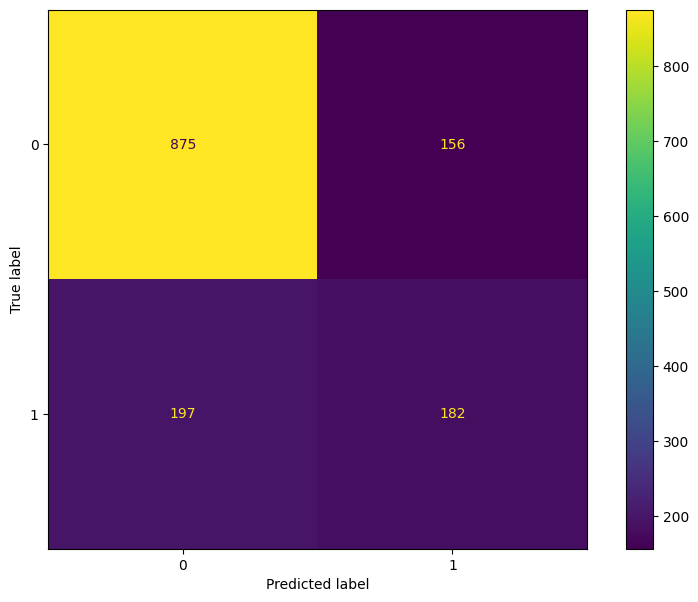

In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_knn.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_knn.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_knn.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
y_pred = grid_knn.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1031
           1       0.54      0.48      0.51       379

    accuracy                           0.75      1410
   macro avg       0.68      0.66      0.67      1410
weighted avg       0.74      0.75      0.74      1410



#### 2. Decision Tree

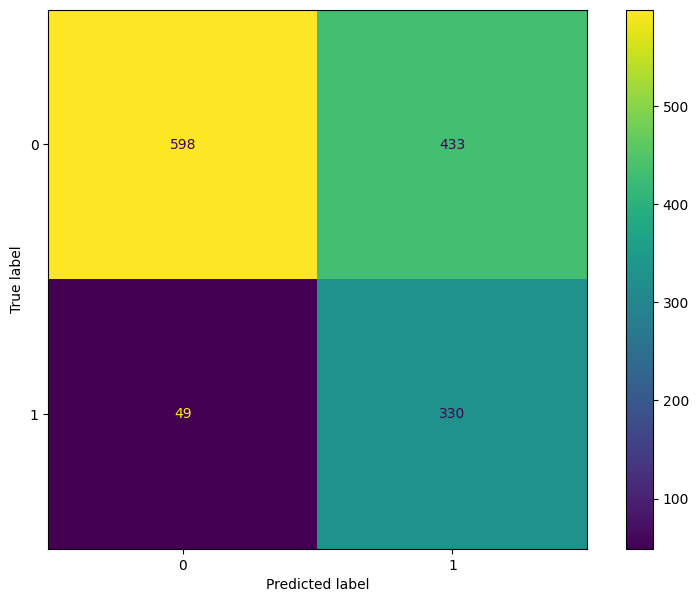

In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_dt.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=grid_dt.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_dt.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
y_pred = grid_dt.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.58      0.71      1031
           1       0.43      0.87      0.58       379

    accuracy                           0.66      1410
   macro avg       0.68      0.73      0.65      1410
weighted avg       0.79      0.66      0.68      1410



#### 3. Random Forest

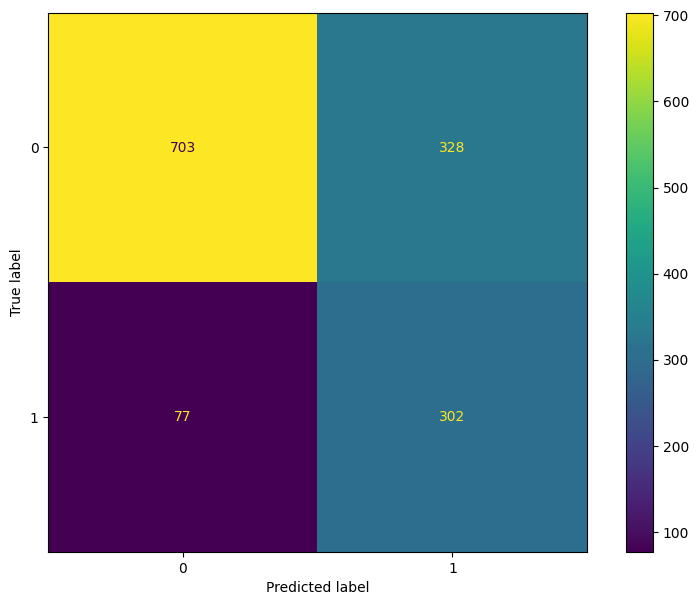

In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_rf.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=grid_rf.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_rf.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
y_pred = grid_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.78      1031
           1       0.48      0.80      0.60       379

    accuracy                           0.71      1410
   macro avg       0.69      0.74      0.69      1410
weighted avg       0.79      0.71      0.73      1410



#### 4. SVM (Classifier)

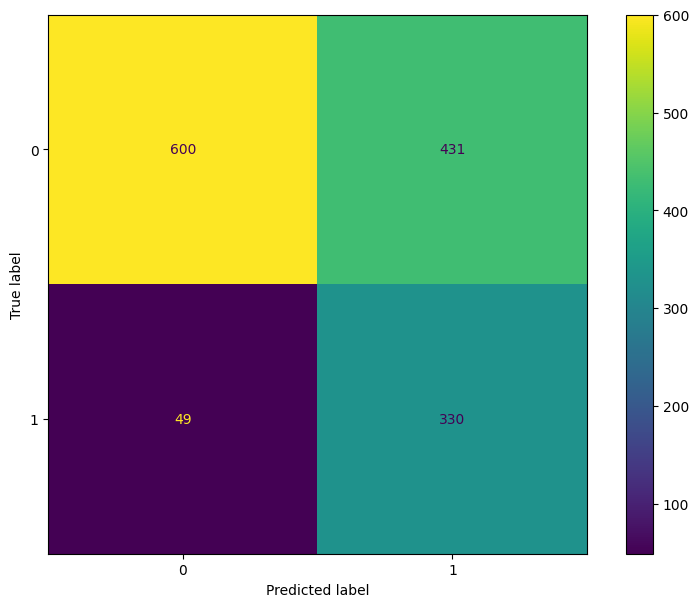

In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_svm.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_svm.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_svm.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
y_pred = grid_svm.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.58      0.71      1031
           1       0.43      0.87      0.58       379

    accuracy                           0.66      1410
   macro avg       0.68      0.73      0.65      1410
weighted avg       0.79      0.66      0.68      1410



#### 5. Logistic Regression

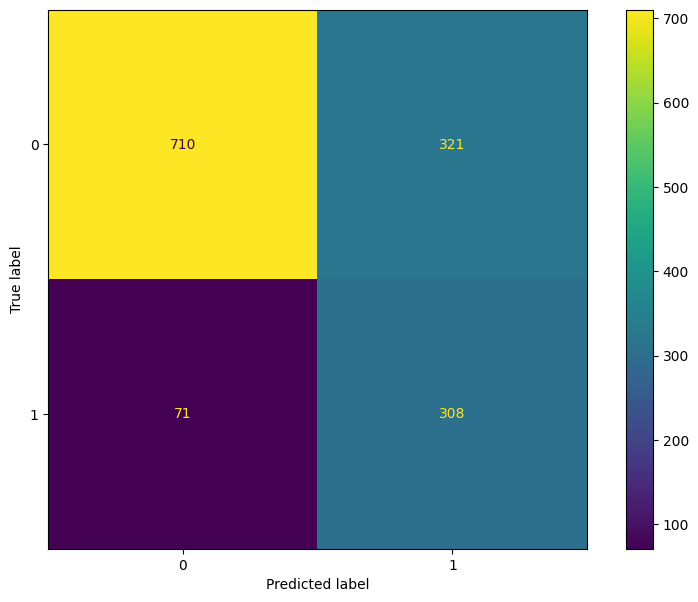

In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_lr.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_lr.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_lr.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
y_pred = grid_lr.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1031
           1       0.49      0.81      0.61       379

    accuracy                           0.72      1410
   macro avg       0.70      0.75      0.70      1410
weighted avg       0.80      0.72      0.74      1410



## Evaluation

Berdasarkan hasil Training dan Testing (dari parameter terbaik) didapatkan bahwa, menggunakan Recall sebagai metrik evaluasinya:

1. KNN (Train: 0.51 Test: 0.48) -> Underfitting (skor rendah)
2. Decision Tree (Train: 0.890153 Test: 0.87)  -> bisa dikatakan fit dengan baik. Gap train-test kecil (hanya sekitar 0.02), yang artinya model generalisasi-nya bagus. Tidak terlalu overfitting walaupun Decision Tree rentan overfit.
3. Random Forest (Train: 0.818 Test: 0.80) -> performa yang cukup stabil, meski skornya sedikit lebih rendah dibanding Decision Tree. Jadi cuku stabil, tidak terlalu overfitting.
4. SVM Classifier (Train: 0.890153 Test: 0.87) -> menandakan model generalize dengan baik. cenderung cukup stabil atau tidak terlalu overfitting.
5. Logistic Regression (Train: 0.815 Test: 0.81)  -> menandakan model generalize dengan baik. cenderung cukup stabil atau tidak terlalu overfitting.

Interpretasi:
> Decision Tree memiliki nilai recall yang cukup tinggi di train dan test set dibandingkan model lainnya → hal ini menunjukkan bahwa model cukup baik dalam mengenali pelanggan yang berpotensi churn. Selain itu, gap antara train dan test yang kecil (±0.02) menandakan bahwa model mampu melakukan generalisasi dengan baik, meskipun Decision Tree secara umum rentan terhadap overfitting.

> Random Forest, SVM, dan Logistic Regression menunjukkan performa yang stabil dengan gap kecil antara train dan test set. Namun, nilai recall-nya cenderung lebih rendah dari Decision Tree, yang mengindikasikan bahwa model-model ini belum cukup optimal dalam mengenali pola pelanggan yang akan churn.

> KNN memiliki performa paling rendah di antara semua model, dengan skor recall yang rendah di train maupun test set. Hal ini menunjukkan model mengalami underfitting yang cukup parah, kemungkinan besar karena tidak mampu menangkap kompleksitas pola dalam data.

Secara keseluruhan, semua model menunjukkan tantangan dalam mendeteksi kelas minoritas (churn), yang terlihat dari nilai recall yang belum mencapai tingkat optimal —> ini merupakan hal umum dalam permasalahan data yang tidak seimbang (imbalanced class).


Sehingga, model terbaiknya: Decision Tree adalah model terbaik berdasarkan metrik recall, dengan performa paling tinggi dan stabil antara train dan test set. Model ini mampu mengenali pelanggan yang churn lebih baik dibanding model lain, dan generalisasinya cukup baik (tidak overfit maupun underfit). Selain itu, dari segi interpretabilitas, efisiensi, dan kemudahan komunikasi ke tim non-teknis (misalnya tim marketing atau manajemen), maka Decision Tree lebih direkomendasikan dibandingkan dengan SVM.

Tapi kalau kamu ingin model yang lebih general, lebih tahan overfit, dan siap untuk dioptimasi lebih lanjut (misal dengan kernel trick, tuning C/gamma), maka SVM juga layak dipilih.

Perlu diingat bahwa:
Model tetap perlu diimprove lebih lanjut, terutama karena kita sedang menangani kasus data imbalance.

**<h3> Adapun Saran dan Rekomendasi terkait dari hasil di atas: <h3>**
- Mungkin Perlu dilakukan SMOTE untuk oversampling kelas churn sebelum dilatih, agar memaksimalkan agar model memiliki representasi churn yang lebih baik.
- Melakukan tuning parameter lebih luas dan eksplorasi
- Bisa mempertimbangkan fitur tambahan atau melakukan feature engineering atau pengayaan data, karena model mungkin gagal mengenali pola churn bukan karena algoritma yang salah, tetapi karena informasi yang tersedia masih terbatas.
- Dari segi bisnis, Mengingat churn berdampak besar terhadap revenue, model yang lebih baik mendeteksi pelanggan akan churn meskipun sedikit mengorbankan akurasi, tetap lebih bernilai strategis. a) Menghubungi pelanggan yang berisiko churn. b) Menawarkan promo / loyalty program secara targeted.
- Dalam konteks kasus churn detection yang melibatkan stakeholder non-teknis dan butuh tindakan cepat (seperti memberi promo ke pelanggan churn), Decision Tree lebih cocok karena mudah dijelaskan, cukup akurat, dan cepat dijalankan.

# Coba SMOTE

**Karena data dicoba SMOTE, jika smote maka wajib model-model selain KNN perlu dilakukan random state saja, tanpa class_weight. Kenapa, KNN tidak perlu, karena sifatnya deterministik dimana KNN tidak melibatkan proses acak. Kenapa tidak perlu class_weight karena sudah seimbang, takutnya nanti berlebihan jadinya bias**

In [ ]:
#pisahkan numerik dan non numerik
numerik_df = ['Tenure', 'MonthlyCharges']
non_numerik_df = [col for col in X_train.columns if col not in numerik_df]

In [ ]:
# Pastikan y_train dalam bentuk 1D array
y_train_1d = y_train.values.ravel()

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_1d)

# Cek hasil distribusi setelah resampling
import numpy as np
print(np.bincount(y_train_resampled))  # Harusnya 1:1

[4143 4143]


In [ ]:
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled[numerik_df])

In [ ]:
#gabung
X_train_resampled_scaled = pd.concat([
    X_train_resampled[non_numerik_df].reset_index(drop=True),
    pd.DataFrame(X_train_resampled_scaled, columns=numerik_df)
], axis=1)

In [ ]:
X_train_resampled_scaled

,Gender,SeniorCitizen,Partner,Dependents,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_One year,Contract_Two year,Tenure,MonthlyCharges
0,0,0,0,0,1,False,True,False,False,False,1.260398,0.951943
1,0,0,0,0,1,True,False,False,False,False,-0.945417,0.608587
2,1,0,1,0,0,False,False,False,False,True,1.759828,-1.481033
3,1,1,1,0,1,False,True,False,False,False,1.385256,0.495869
4,0,0,0,0,1,True,False,False,False,False,-0.487607,-0.091999
...,...,...,...,...,...,...,...,...,...,...,...,...
8281,1,0,0,0,1,False,True,True,False,False,-1.111894,-1.670249
8282,1,0,0,0,1,False,True,False,False,False,-0.612464,0.789489
8283,0,0,0,0,0,True,True,False,False,False,-0.154653,-0.471953
8284,0,0,0,0,0,False,True,False,False,False,-1.111894,0.393138


## Training

### 1. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_knn = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn_after = GridSearchCV(KNeighborsClassifier(), param_knn, scoring='recall', cv=5)
grid_knn_after.fit(X_train_resampled_scaled, y_train_resampled)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [2, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_knn_after.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
19,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.848656,1
17,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.847451,2
9,"{'metric': 'euclidean', 'n_neighbors': 9, 'wei...",0.844551,3
7,"{'metric': 'euclidean', 'n_neighbors': 7, 'wei...",0.840933,4
15,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.838277,5
5,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.834174,6
13,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.831760,7
3,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.827173,8
11,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.818969,9
16,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.818488,10


### 2. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_dt_after = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt, scoring='recall', cv=5)
grid_dt_after.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_dt_after.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
6,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.817281,1
7,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.815109,2
19,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.814620,3
18,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.811724,4
8,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.811489,5
20,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.809553,6
9,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.805211,7
21,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.800381,8
4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.794825,9
5,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.794825,9


### 3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5)
}

grid_rf_after = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, scoring='recall', cv=5)
grid_rf_after.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_rf_after.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
2,"{'max_depth': 1, 'n_estimators': 30}",0.838525,1
23,"{'max_depth': 5, 'n_estimators': 40}",0.819933,2
4,"{'max_depth': 1, 'n_estimators': 50}",0.818250,3
22,"{'max_depth': 5, 'n_estimators': 30}",0.816556,4
24,"{'max_depth': 5, 'n_estimators': 50}",0.816314,5
18,"{'max_depth': 4, 'n_estimators': 40}",0.815595,6
19,"{'max_depth': 4, 'n_estimators': 50}",0.810042,7
5,"{'max_depth': 2, 'n_estimators': 10}",0.808829,8
17,"{'max_depth': 4, 'n_estimators': 30}",0.804976,9
15,"{'max_depth': 4, 'n_estimators': 10}",0.804491,10


### 4. SVM (Classifier)

In [ ]:
from sklearn.svm import SVC

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm_after = GridSearchCV(SVC(random_state=42), param_svm, scoring='recall', cv=5)
grid_svm_after.fit(X_train_resampled_scaled, y_train_resampled)


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_svm_after.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
5,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",0.911659,1
11,"{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}",0.861454,2
2,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.843595,3
13,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.843592,4
14,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.841183,5
8,"{'C': 1, 'gamma': 'scale', 'kernel': 'poly'}",0.839253,6
16,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.837561,7
17,"{'C': 10, 'gamma': 'auto', 'kernel': 'poly'}",0.833700,8
7,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.833697,9
10,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.828145,10


### 5. Logistic Regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# Buat pipeline
pipeline_lr = Pipeline([
    ('clf', LogisticRegression(
        solver='liblinear',
        random_state=42
    ))
])

# Parameter grid
param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

# Grid search
grid_lr_after = GridSearchCV(pipeline_lr, param_lr, cv=5, scoring='recall')
grid_lr_after.fit(X_train_resampled_scaled, y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__penalty': ['l1', 'l2']},
             scoring='recall')

In [ ]:
# the results
cv_result = pd.DataFrame(grid_lr_after.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
0,"{'clf__C': 0.01, 'clf__penalty': 'l1'}",0.798460,1
2,"{'clf__C': 0.1, 'clf__penalty': 'l1'}",0.790975,2
3,"{'clf__C': 0.1, 'clf__penalty': 'l2'}",0.790733,3
5,"{'clf__C': 1, 'clf__penalty': 'l2'}",0.789527,4
1,"{'clf__C': 0.01, 'clf__penalty': 'l2'}",0.789286,5
6,"{'clf__C': 10, 'clf__penalty': 'l1'}",0.789044,6
7,"{'clf__C': 10, 'clf__penalty': 'l2'}",0.789044,6
4,"{'clf__C': 1, 'clf__penalty': 'l1'}",0.788804,8


## Testing

### 1. KNN

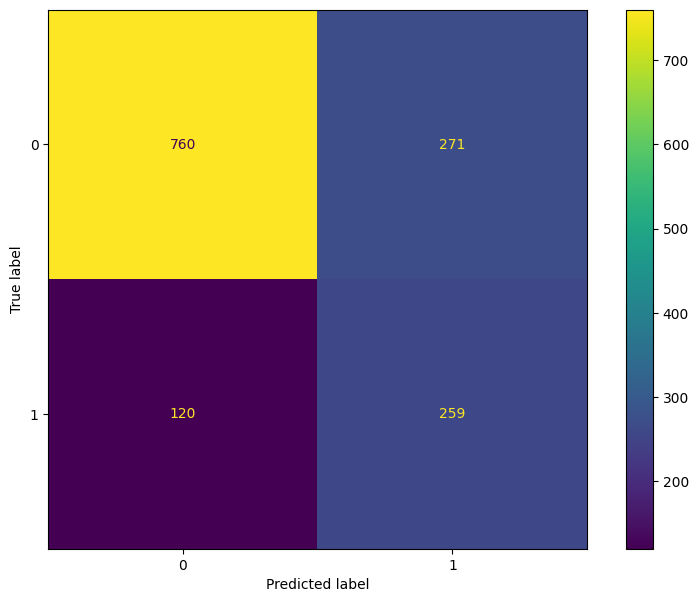

              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1031
           1       0.49      0.68      0.57       379

    accuracy                           0.72      1410
   macro avg       0.68      0.71      0.68      1410
weighted avg       0.76      0.72      0.73      1410



In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_knn_after.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_knn_after.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_knn_after.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### 2. Decision Tree

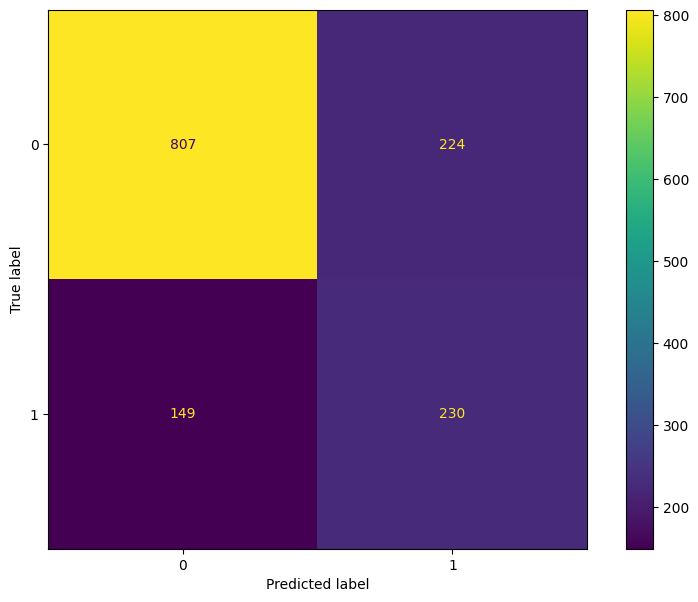

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1031
           1       0.51      0.61      0.55       379

    accuracy                           0.74      1410
   macro avg       0.68      0.69      0.68      1410
weighted avg       0.75      0.74      0.74      1410



In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_dt_after.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=grid_dt_after.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_dt_after.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### 3. Random Forest

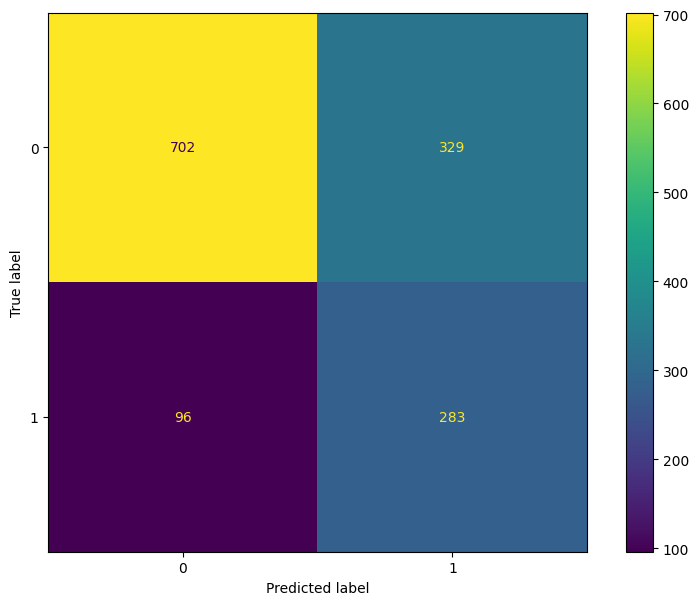

              precision    recall  f1-score   support

           0       0.88      0.68      0.77      1031
           1       0.46      0.75      0.57       379

    accuracy                           0.70      1410
   macro avg       0.67      0.71      0.67      1410
weighted avg       0.77      0.70      0.71      1410



In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_rf_after.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=grid_rf_after.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_rf_after.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### 4. SVM (Classifier)

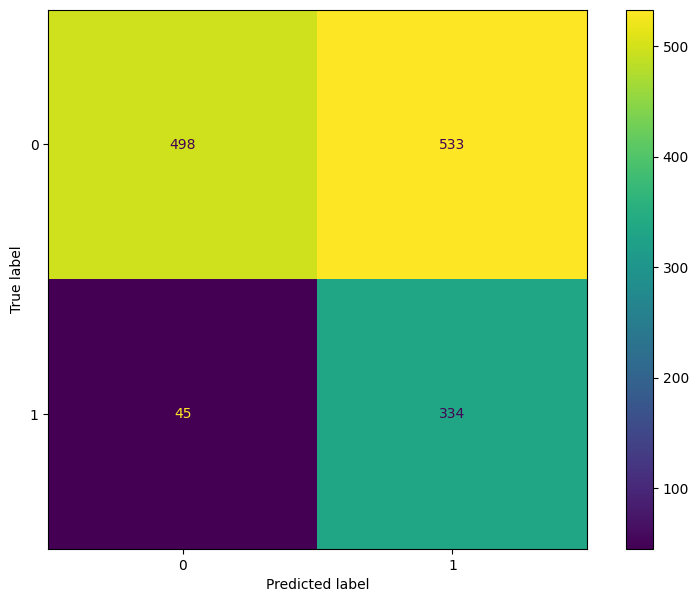

              precision    recall  f1-score   support

           0       0.92      0.48      0.63      1031
           1       0.39      0.88      0.54       379

    accuracy                           0.59      1410
   macro avg       0.65      0.68      0.58      1410
weighted avg       0.77      0.59      0.61      1410



In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_svm_after.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_svm_after.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_svm_after.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### 5. Logistic Regression

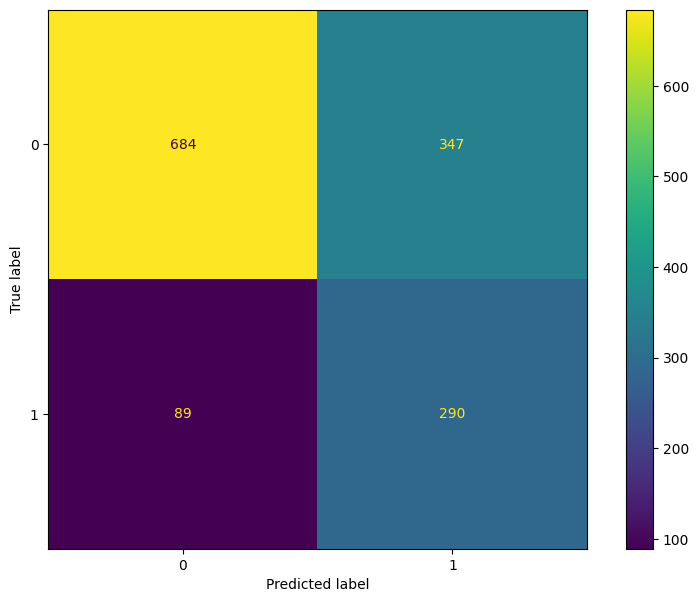

              precision    recall  f1-score   support

           0       0.88      0.66      0.76      1031
           1       0.46      0.77      0.57       379

    accuracy                           0.69      1410
   macro avg       0.67      0.71      0.66      1410
weighted avg       0.77      0.69      0.71      1410



In [ ]:
# the confusion matrix (the best model from gridcv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = grid_lr_after.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=grid_lr_after.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=grid_lr_after.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## Evaluation


Ternyata, setelah dilakukan SMOTE, terlihat bahwa berdasarkan recall:

1. KNN (Train: 0.8486 Test: 0.68) -> Overfitting (tidak cocok model kompleks)
2. Decision Tree (Train: 0.8172 Test: 0.61)  -> Overfitting (tidak cocok model kompleks)
3. Random Forest (Train: 0.8385 Test: 0.75) -> Overfitting (tidak cocok model kompleks)
4. SVM Classifier (Train: 0.9116 Test: 0.88) -> Overfitting (tidak cocok model kompleks) tapi cukup bagus
5. Logistic Regression (Train: 0.798 Test: 0.77)  -> Overfitting (tidak cocok model kompleks)

Interpretasi:
> SVM Classifier memiliki recall tertinggi di train dan test set setelah SMOTE (Train: 0.91, Test: 0.88) → ini menunjukkan model sangat mampu mendeteksi pelanggan churn, dengan performa yang stabil dan generalization yang baik. Gap antara train dan test kecil (0.03) → tidak overfitting, cocok untuk deployment.

> Logistic Regression memiliki recall yang relatif tinggi juga (Train: 0.798, Test: 0.77) dengan gap kecil, menunjukkan model sederhana tapi stabil, cocok untuk baseline yang ringan secara komputasi dan tetap bisa mendeteksi churn dengan cukup baik.

> Random Forest, Decision Tree, dan KNN mengalami overfitting cukup tinggi setelah SMOTE. Meskipun train recall-nya tinggi, test recall-nya jauh lebih rendah, menunjukkan bahwa model hanya "hafal" data training tapi gagal mengenali pola pada data baru. Ini umum terjadi saat model kompleks dilatih pada data hasil oversampling.

Secara umum, SMOTE berhasil meningkatkan recall pada kelas minoritas (churn), tetapi model kompleks seperti KNN, DT, dan RF kurang cocok bila tidak disertai dengan tuning tambahan atau regularisasi yang lebih kuat.

Dengan Demikian, SVM Classifier adalah model terbaik setelah SMOTE → dengan recall tinggi dan generalisasi baik, sangat cocok untuk mendeteksi pelanggan churn secara efektif.

Jika dibandingkan Tanpa SMOTE,
> Mayoritas model justru mengalami overfitting. Hal ini terlihat dari nilai recall training yang tinggi, namun recall test yang menurun cukup drastis (terutama pada Decision Tree dan KNN). Dalam artian, bahwa Model belajar terlalu baik dari data sintetis (hasil SMOTE), tetapi gagal generalisasi saat diuji di data test yang sebenarnya.

> Model yang paling stabil dan tetap bagus performanya hanyalah SVM (walaupun yang SMOTE cukup sedikit overfitting. Hal ini, karena SVM bisa mengakomodasi data seimbang hasil SMOTE tanpa mengalami overfitting berlebihan, terbukti dari nilai recall test yang tinggi (0.88) dan gap kecil dengan train recall.

> SMOTE menambahkan data sintetis yang bisa membuat model seperti Decision Tree, KNN, dan Random Forest "menghafal" pola palsu dalam artian tidak tau pola data aslinya. Akibatnya, Model jadi kehilangan kemampuannya untuk generalisasi ke data nyata.

Adapun Rekomendasi dan saran dari hasil SMOTE:
1. Menggunakan model SVM setelah SMOTE, karena performanya konsisten dan tidak overfit, cocok untuk kasus churn prediction pada data imbalance.
2. Menghindari model seperti Decision Tree dan KNN pasca-SMOTE, karena menunjukkan overfitting berat.
3. Mempertimbangkan  Logistic Regression sebagai baseline model, jika ingin model yang ringan, cepat, dan tetap cukup akurat.
4. Jika ingin model pohon tetap digunakan, lebih baik eksplorasi teknik balancing lain seperti class weight atau kombinasi SMOTE + Tomek Links untuk mengurangi noise.
5. Menggunakan model yang lebih robust terhadap data sintetis, memperluas parameter yang lebih optimal agar hasil maksimal, bisa menambah data agar bisa lebih maksimal dalam memahami pola data dan mengurangi imbalanced data, sekaligus melakukan improving baik dari segi model ataupun penggunaan tuningnya.

<hr></hr>

**Berdasarkan hasil evaluasi model sebelum dan sesudah diterapkan SMOTE, dapat disimpulkan bahwa model tanpa SMOTE memberikan hasil yang lebih baik secara keseluruhan. Model non-SMOTE menunjukkan performa yang lebih stabil, terlihat dari nilai recall yang relatif tinggi dan konsisten antara data training dan testing. Sebaliknya, model dengan SMOTE justru cenderung mengalami overfitting, karena model "tertipu" oleh data sintetis yang terlalu ideal dan tidak merepresentasikan data asli dengan baik. Dari seluruh model yang diujikan, Decision Tree tanpa SMOTE merupakan model yang paling direkomendasikan untuk digunakan dalam deployment, terutama dalam konteks prediksi pelanggan churn. Meskipun SVM juga memiliki performa recall yang sangat mirip, Decision Tree dipilih karena lebih interpretable dan mudah dijelaskan kepada stakeholders non-teknis, seperti tim marketing atau manajemen. Hal ini penting karena strategi retensi pelanggan perlu didasarkan pada insight yang dapat dipahami dan ditindaklanjuti secara langsung.**




**Tujuan utama dari analisis ini adalah untuk mendeteksi pelanggan yang berpotensi churn agar perusahaan bisa mengambil langkah preventif lebih awal—seperti memberikan penawaran khusus, program loyalitas, atau intervensi lainnya. Oleh karena itu, recall menjadi metrik utama, karena kita lebih mementingkan kemampuan model untuk menangkap sebanyak mungkin pelanggan yang benar-benar akan churn, meskipun dengan sedikit pengorbanan pada precision.**

Dengan model Decision Tree yang stabil dan cukup tinggi recall-nya, serta dapat dengan mudah dijelaskan, maka perusahaan dapat:

- Menyusun strategi retensi yang lebih tepat sasaran

- Mengalokasikan sumber daya promosi secara efisien

- Meningkatkan loyalitas dan mengurangi kehilangan pelanggan